In [1]:
import os 
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns

import sys
sys.path.extend(['../..'])
from nebula.evaluation import read_cv_metrics_file

PLOT_OUT_FOLDER = os.path.join("..", "img", "_crossValidationPlots")
os.makedirs(PLOT_OUT_FOLDER, exist_ok=True)

In [ ]:
def readCrossValidationFolder(folder, diffExtractor, extraFileFilter=None):
    if extraFileFilter:
        metricFiles = [x for x in os.listdir(folder) if x.endswith(".json") and extraFileFilter(x)]
    else:
        metricFiles = [x for x in os.listdir(folder) if x.endswith(".json")]
    fileToField = dict(zip(metricFiles, [diffExtractor(x) for x in metricFiles]))
    # sort fileToFiel based on values
    fileToField = {k: v for k, v in sorted(fileToField.items(), key=lambda item: int(item[1]))}

    dfDict = dict()
    timeDict = dict()
    for file in fileToField:
        dfMetrics, avgEpochTime = read_cv_metrics_file(os.path.join(folder, file))
        dfDict[fileToField[file]] = dfMetrics
        timeDict[fileToField[file]] = avgEpochTime
        
    return dfDict, timeDict


def plotListElementLengths(list_of_strings, xlim=None, outfile=None, bins=100, ax=None):
    lengths = [len(x) for x in list_of_strings]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.hist(lengths, bins=bins)
    ax.set_title("Histogram of list element lengths")
    if xlim:
        ax.set_xlim(xlim)
    ax.set_yscale("log")
    ax.set_ylabel("Count (log)")
    ax.grid(which="both")
    if outfile:
        plt.tight_layout()
        plt.savefig(outfile)
    return lengths, ax

def plotCrossValidationDict(dfDict, key, ax=None, legendTitle=None, savePath=None):
    if ax is None:
        fig, ax = plt.subplots()
    for diff in dfDict:
        x = dfDict[diff].index.values
        y = dfDict[diff][f"{key}_avg"]
        yerr = dfDict[diff][f"{key}_std"]
        if (yerr > 0).any():
            capsize=10
        else:
            capsize=0
        ax.errorbar(x, y, yerr=yerr, label=diff, marker="o", capsize=capsize)
    ax.set_xlabel("FPR")
    ax.set_ylabel(f"{key}".upper())
    ax.set_title(f"{key.upper()} vs FPR")
    ax.legend(title=legendTitle)
    # add grid
    ax.grid()
    if savePath:
        plt.tight_layout()
        plt.savefig(savePath)

def plotCrossValidationTrainingTime(timeDict, ax=None, savePath=None, xlabel=""):
    if ax is None:
        fig, ax = plt.subplots()
    try:
        if any([x for x in timeDict if "_" in x]):
            x = [x for x in timeDict]
        else:
            x = [int(x) for x in timeDict]
    except ValueError:
        x = [x for x in timeDict]
    y = [timeDict[str(value)] for value in x]
    ax.plot(x, y, marker="o")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Training Time (s)")
    ax.set_title(f"Average Epoch Time vs {xlabel}")
    # set y limit to be -10 + 10 of min max y values
    #ax.set_ylim(min(y) - 10, max(y) + 10)
    # add grid
    ax.grid()
    ax.set_yscale('log')
    if savePath:
        plt.tight_layout()
        plt.savefig(savePath)

def plotCrossValidation_TPR_F1_Time(dfDict, timeDict, title=None, legentTitle=None, savePath=None, figSize=(18, 6)):
    fig, ax = plt.subplots(1, 3, figsize=figSize)
    plt.suptitle(title, fontsize=16)

    plotCrossValidationDict(dfDict, "tpr", legendTitle=legentTitle, ax=ax[0])
    plotCrossValidationDict(dfDict, "f1", legendTitle=legentTitle, ax=ax[1])
    plotCrossValidationTrainingTime(timeDict, ax=ax[2], xlabel=legentTitle)

    if savePath:
        plt.tight_layout()
        plt.savefig(savePath)
    return fig, ax

def plotCrossValidationFolder(folder, field, diffExtractor, extraFileFilter=None, savePath=None, title=None, figSize=(18, 6)):
    dfDict, timeDict = readCrossValidationFolder(folder, diffExtractor, extraFileFilter=extraFileFilter)
    if title is None:
        title = folder
    plotCrossValidation_TPR_F1_Time(dfDict, timeDict, title=title, legentTitle=field, savePath=savePath, figSize=figSize) 

def plotCrossValidationFieldvsKeys(dfDict, field, keyName, fpr, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    keys = dfDict.keys()
    y = [dfDict[key].loc[str(fpr)][f"{field}_avg"] for key in keys]
    yerr = [dfDict[key].loc[str(fpr)][f"{field}_std"] for key in keys]
    ax.errorbar(keys, y, yerr=yerr, marker="o", capsize=10)
    ax.set_xlabel(f"{keyName}")
    ax.set_ylabel(f"{field}".upper())
    ax.set_title(f"{field.upper()} vs {keyName} at FPR={fpr}")
    # add grid
    ax.grid()

def plotVocabSizeMaxLenTests(inFolder, plotOutFolder, maxLen=1024, vocabSize=2000):
    field = "vocabSize"
    diffExtractor = lambda x: x.split(field)[1].split("_")[1]

    myFilter = f"maxLen_{maxLen}_"
    extraFileFilter = lambda x: myFilter in x

    title = f"{inFolder.split('_')[0]} {field}; {'='.join(myFilter.split('_')[:-1])}"
    pngPath = os.path.join(plotOutFolder, title.replace(" ", "_").replace("=", "_").replace(";", "").replace("crossValidation", "")+".png")
    plotCrossValidationFolder(inFolder, field, diffExtractor, extraFileFilter, title=title, savePath=pngPath)

    field = "maxLen"
    diffExtractor = lambda x: x.split(field)[1].split("_")[1]

    myFilter = f"vocabSize_{vocabSize}_"
    extraFileFilter = lambda x: myFilter in x

    title = f"{inFolder.split('_')[0]} {field}; {'='.join(myFilter.split('_')[:-1])}"
    pngPath = os.path.join(plotOutFolder, title.replace(" ", "_").replace("=", "_").replace(";", "").replace("crossValidation", "")+".png")
    plotCrossValidationFolder(inFolder, field, diffExtractor, extraFileFilter, title=title, savePath=pngPath)

def plotVocabSizeMaxLenArchComparison(vmFolders, maxLen=512, vocabSize=2000, savePath=None, legendTitle=None, title="Architecture", figSize=(18, 6), legendValues=None, fprs=['0.0001', '0.001', '0.01', '0.1']):
    metricDict = dict()
    timeDict = dict()
    for folder in vmFolders:
        key = folder.split("\\")[-1].rstrip("_VocabSize_maxLen").rstrip("_PositEmbFix")
        try:
            metricFile = [x for x in os.listdir(folder) if f"maxLen_{maxLen}_vocabSize_{vocabSize}" in x][0]
        except IndexError:
            metricFile = [x for x in os.listdir(folder) if f"metrics" in x][0]
        metricFile = os.path.join(folder, metricFile)
        dfDict, timeValue = read_cv_metrics_file(metricFile)
        dfDict = dfDict[dfDict.index.isin(fprs)]
        metricDict[key] = dfDict
        timeDict[key] = timeValue
    plotTitle = f"{title} Comparison"
    fig, ax = plotCrossValidation_TPR_F1_Time(metricDict, timeDict, legentTitle=legendTitle, savePath=savePath, title=plotTitle, figSize=figSize)
    if legendValues:
                # modify legend for first plot
        handles, _ = ax[0].get_legend_handles_labels()
        ax[0].legend(handles, legendValues[0], title=title)
        # do the saame for ax[1]
        handles, _ = ax[1].get_legend_handles_labels()
        ax[1].legend(handles, legendValues[0], title=title)
        # set basePaths as xticklabels for ax[2]
        ax[2].set_xticks(ax[2].get_xticks())
        # wrap labels to fit correctly in plot
        ax[2].set_xlabel("")
        _ = ax[2].set_xticklabels(legendValues[1])
    return metricDict, timeDict, fig, ax

def plotHeatmap(df, title, rangeL=None, xlabel=None, ylabel=None, savePath=None, figSize=(12, 4), ax=None, cmap=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figSize)
    # plot heatmap with vmin and vmax -5 and +5 from min and max values in df
    if rangeL:
        vmin = df.min().min() - rangeL
        vmax = df.max().max() + rangeL
    else:
        vmin = None
        vmax = None
    # heatmap with blue colormap
    sns.heatmap(df, ax=ax, annot=True, fmt=".3f", vmin=vmin, vmax=vmax, cmap=cmap)    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if savePath:
        #plt.tight_layout()
        plt.savefig(savePath)

def plotVocabSizeMaxLenHeatmap(inFolder, fpr, savePath=None, rangeL=None, figSize=(14, 5), supTitle=None, vocabSizes=None, maxLens=None, axs=None):
    metricFiles = [file for file in os.listdir(inFolder) if file.endswith(".json")]

    dfHeatTPR = DataFrame()
    dfHeatF1 = DataFrame()
    for file in metricFiles:
        vocabSize = int(file.split("vocabSize")[1].split("_")[1])
        maxLen = int(file.split("maxLen")[1].split("_")[1])
        if vocabSizes and vocabSize not in vocabSizes:
            continue
        if maxLens and maxLen not in maxLens:
            continue
        dfMetric, _ = read_cv_metrics_file(os.path.join(inFolder, file))
        dfHeatTPR.loc[vocabSize, maxLen] = dfMetric["tpr_avg"][fpr]
        dfHeatF1.loc[vocabSize, maxLen] = dfMetric["f1_avg"][fpr]
    dfHeatF1 = dfHeatF1.sort_index().transpose().sort_index(ascending=False)
    dfHeatTPR = dfHeatTPR.sort_index().transpose().sort_index(ascending=False)

    # create 2 plots
    if axs is None:
        _, axs = plt.subplots(1, 2, figsize=figSize)
        if not supTitle:
            plt.suptitle(f"{inFolder.split('_')[0]} with FPR={fpr} for different vocabSize and sequence length", fontsize=14)
        else:
            plt.suptitle(f"{supTitle} with FPR={fpr} for different vocabSize and sequence length", fontsize=14)

    plotHeatmap(dfHeatTPR, f"True-Positive Rate", rangeL=rangeL, xlabel="vocabSize", ylabel="sequence length", ax=axs[0])
    plotHeatmap(dfHeatF1, f"F1-score", rangeL=rangeL, xlabel="vocabSize", ylabel="sequence length", cmap="Blues", ax=axs[1])

    if savePath:
        plt.tight_layout()
        plt.savefig(savePath)

    return axs


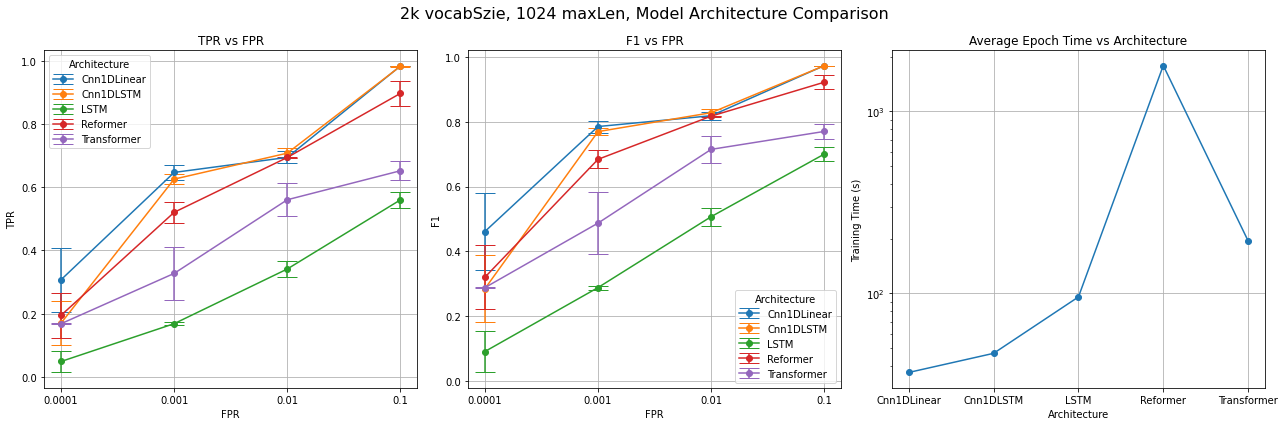

In [2]:
savePath = os.path.join(f"{PLOT_OUT_FOLDER}","_modelArchitectureComparison.png")
title = "2k vocabSzie, 1024 maxLen, Model Architecture"
figSize = (18, 6)
field="Architecture"

cvFolder = os.path.join("crossValidation", "_modelSelection")
whiteList = "Transformer_VocabSize_maxLen"
vmFolders = [os.path.join(cvFolder, x) for x in os.listdir(cvFolder) if "VocabSize_maxLen" in x and x not in whiteList]
_ = plotVocabSizeMaxLenArchComparison(vmFolders, maxLen=1024, vocabSize=2000, savePath=savePath, title=title, legendTitle=field)

## Same tests, but with significantly larger vocabulary -- 50k tokens -- results are weird:

- CNN + Linear architecture benefits significantly from the larger vocabulary
- Transformer has a little better metrics 
- Other architectures (Reformer & LSTM) show worse results.

Pity, especially for Reformer. Might need to rerun tests?

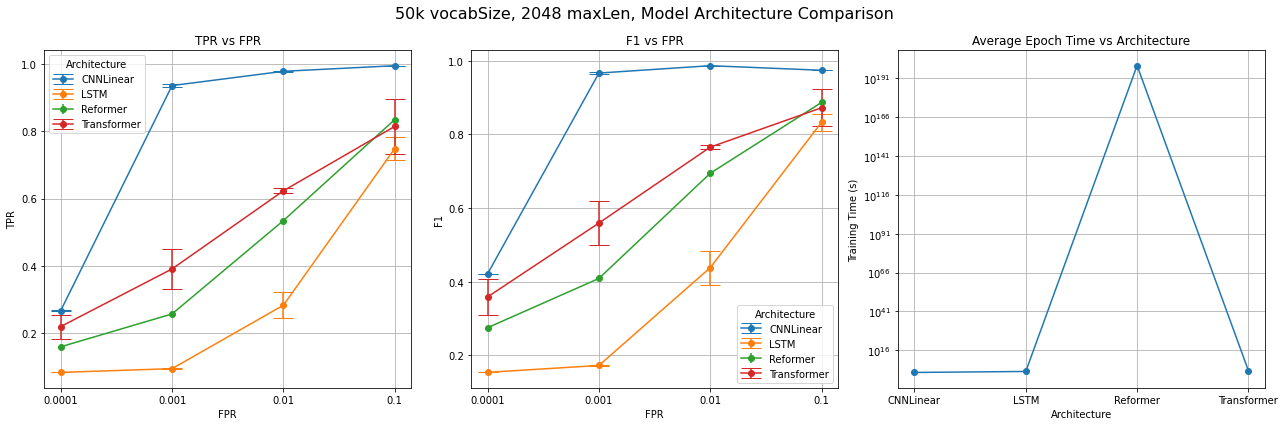

In [3]:
savePath = os.path.join(f"{PLOT_OUT_FOLDER}","_modelArchitectureComparison_50k.png")
title = "50k vocabSize, 2048 maxLen, Model Architecture"
figSize = (18, 6)
field="Architecture"

cvFolder = os.path.join("crossValidation", "_modelSelection_50k")
inFolders = [os.path.join(cvFolder, x) for x in os.listdir(cvFolder)]
_ = plotVocabSizeMaxLenArchComparison(inFolders, maxLen=2048, vocabSize=5e4, savePath=savePath, title=title, legendTitle=field)

## 1D-CNN Neural Network Configuration

array([<AxesSubplot:title={'center':'True-Positive Rate'}, xlabel='vocabSize', ylabel='sequence length'>,
       <AxesSubplot:title={'center':'F1-score'}, xlabel='vocabSize', ylabel='sequence length'>],
      dtype=object)

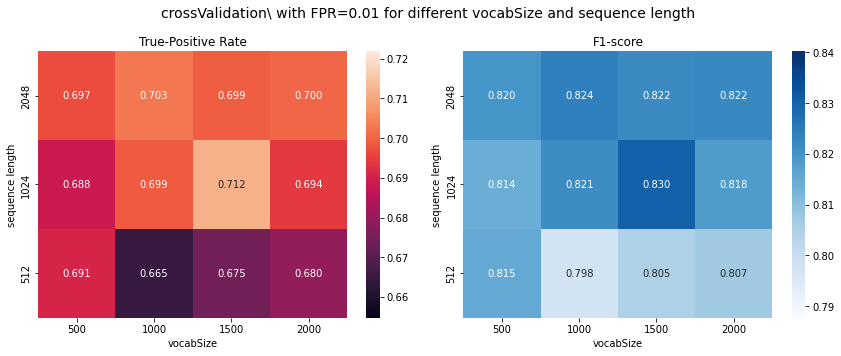

In [3]:
name =  "Cnn1DLinear_VocabSize_maxLen"
inFolder = os.path.join(cvFolder, name)
fpr = "0.01"
savePath = os.path.join(PLOT_OUT_FOLDER, f"{name}_heatmap.png")
plotVocabSizeMaxLenHeatmap(inFolder, fpr, savePath=savePath, rangeL=0.01, figSize=(12, 5))

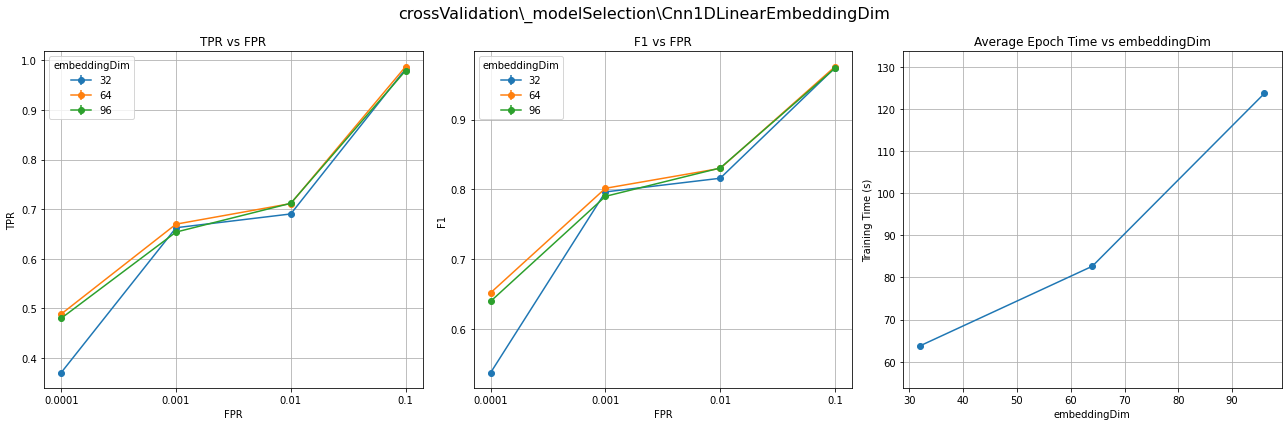

In [4]:
name =  "Cnn1DLinearEmbeddingDim"
inFolder = os.path.join(cvFolder, name)

field = "embeddingDim"
diffExtractor = lambda x: x.split(field)[1].split("_")[1]
fpr = "0.01"
savePath = os.path.join(PLOT_OUT_FOLDER, f"{name}_heatmap.png")

plotCrossValidationFolder(inFolder, field, diffExtractor, savePath=savePath)

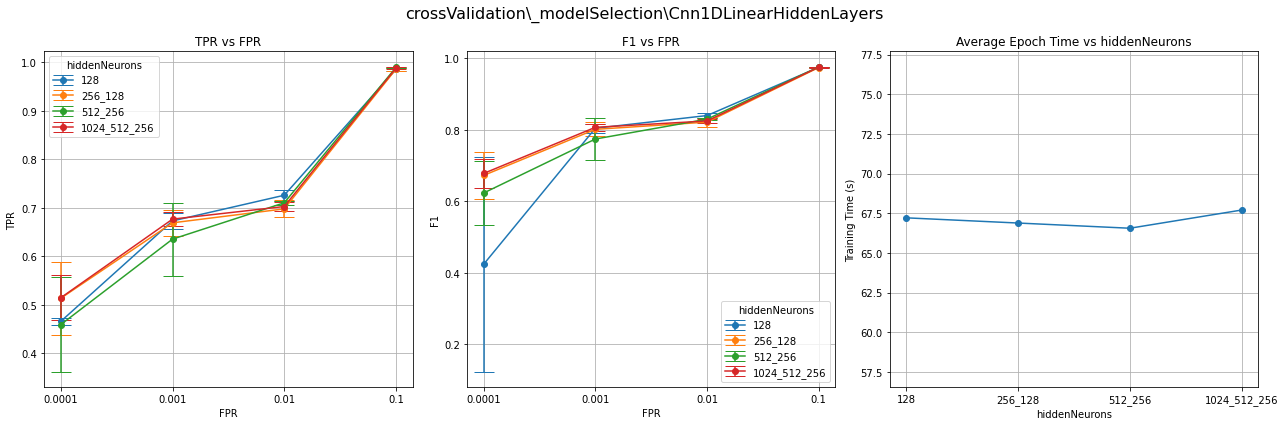

In [5]:
name = "Cnn1DLinearHiddenLayers"
field = "hiddenNeurons"
diffExtractor = lambda x: x.split(field)[1].split("batch")[0].strip("_")

inFolder = os.path.join(cvFolder, name)
savePath = os.path.join(PLOT_OUT_FOLDER, f"{name}.png")

plotCrossValidationFolder(inFolder, field, diffExtractor, savePath=savePath)

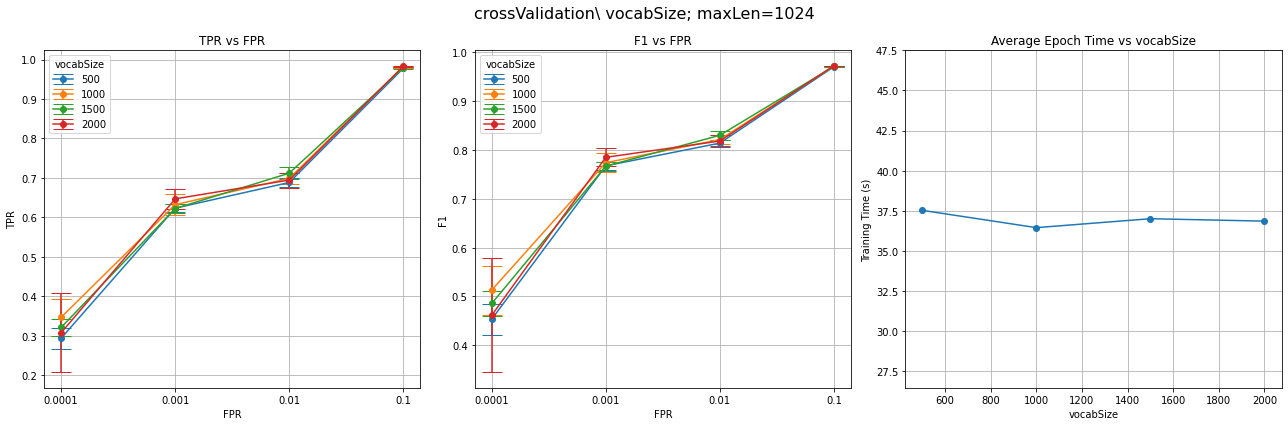

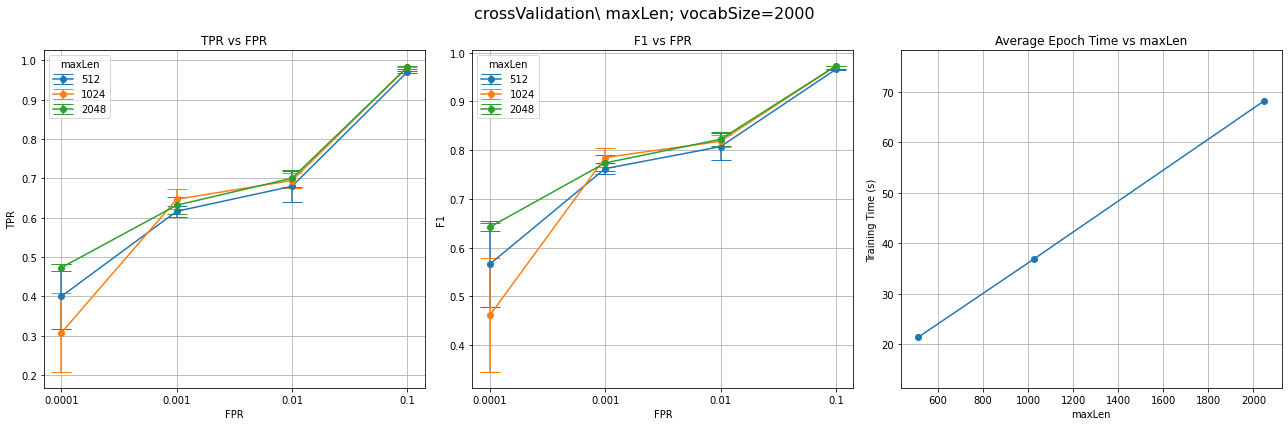

In [6]:
name = "Cnn1DLinear_VocabSize_maxLen"
inFolder = os.path.join(cvFolder, name)

plotVocabSizeMaxLenTests(inFolder, PLOT_OUT_FOLDER)

## 1D-CNN with bidirectional LSTM

array([<AxesSubplot:title={'center':'True-Positive Rate'}, xlabel='vocabSize', ylabel='sequence length'>,
       <AxesSubplot:title={'center':'F1-score'}, xlabel='vocabSize', ylabel='sequence length'>],
      dtype=object)

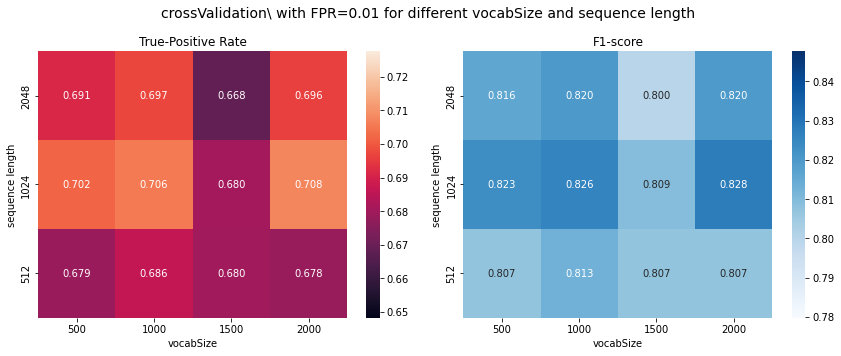

In [7]:
name = "Cnn1DLSTM_VocabSize_maxLen"
inFolder = os.path.join(cvFolder, name)
savePath = os.path.join(PLOT_OUT_FOLDER, f"{name}_heatmap.png")
fpr = "0.01"
plotVocabSizeMaxLenHeatmap(inFolder, fpr, savePath=savePath, rangeL=0.02, figSize=(12, 5))

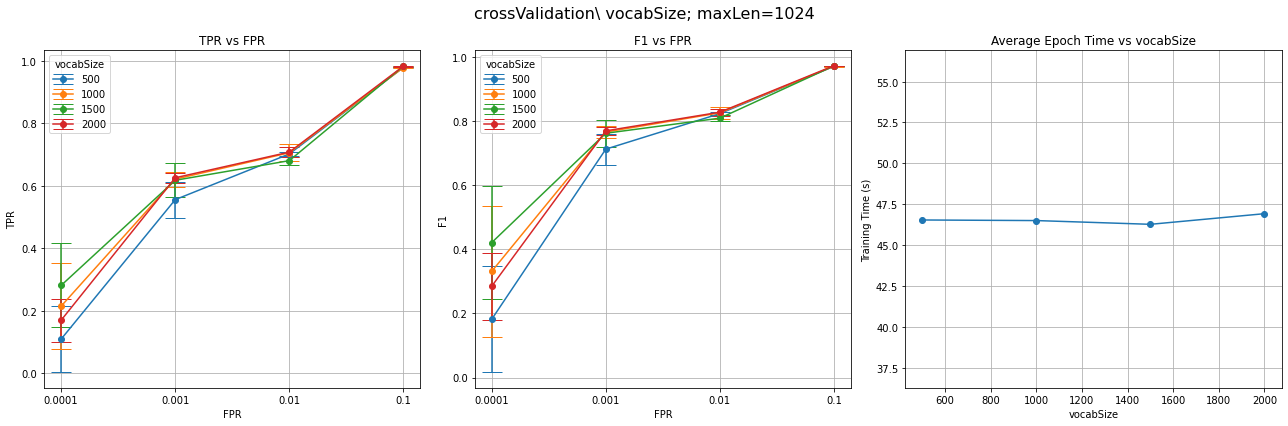

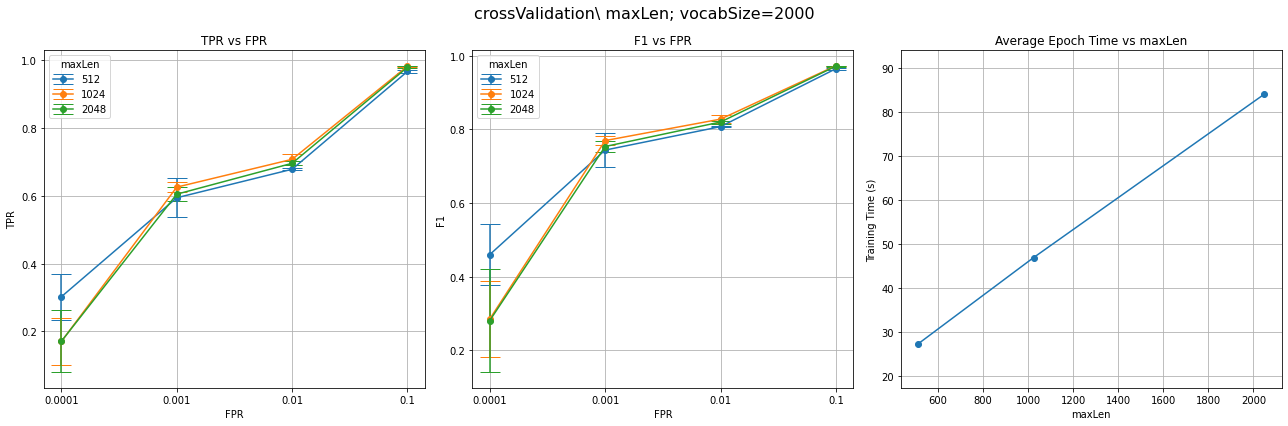

In [8]:
plotVocabSizeMaxLenTests(inFolder, PLOT_OUT_FOLDER)

## Transformer Configuration

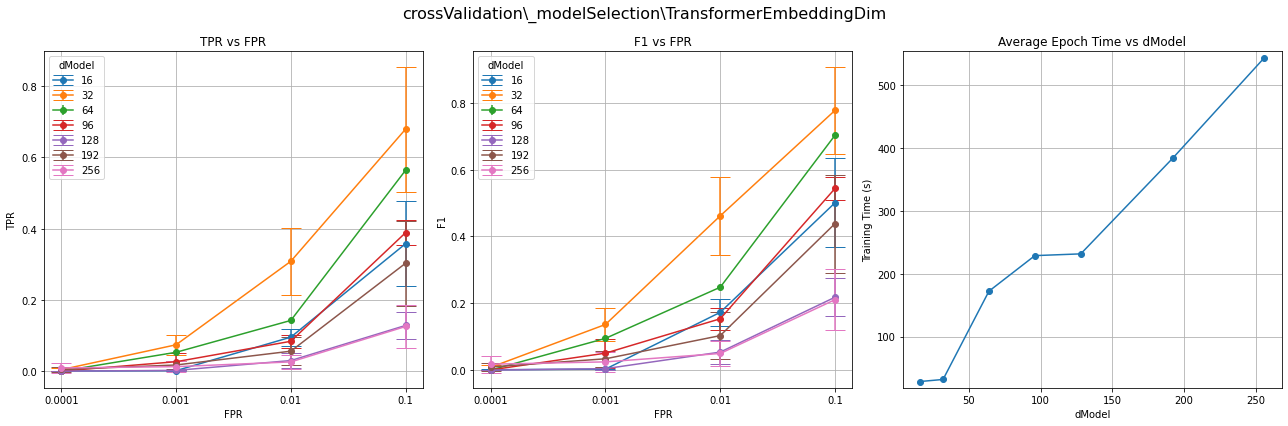

In [9]:
name = "TransformerEmbeddingDim"
inFolder = os.path.join(cvFolder, name)
savePath = os.path.join(PLOT_OUT_FOLDER, f"{name}.png")
field = "dModel"
diffExtractor = lambda x: x.split(field)[1].split("_")[1]

plotCrossValidationFolder(inFolder, field, diffExtractor, savePath=savePath)

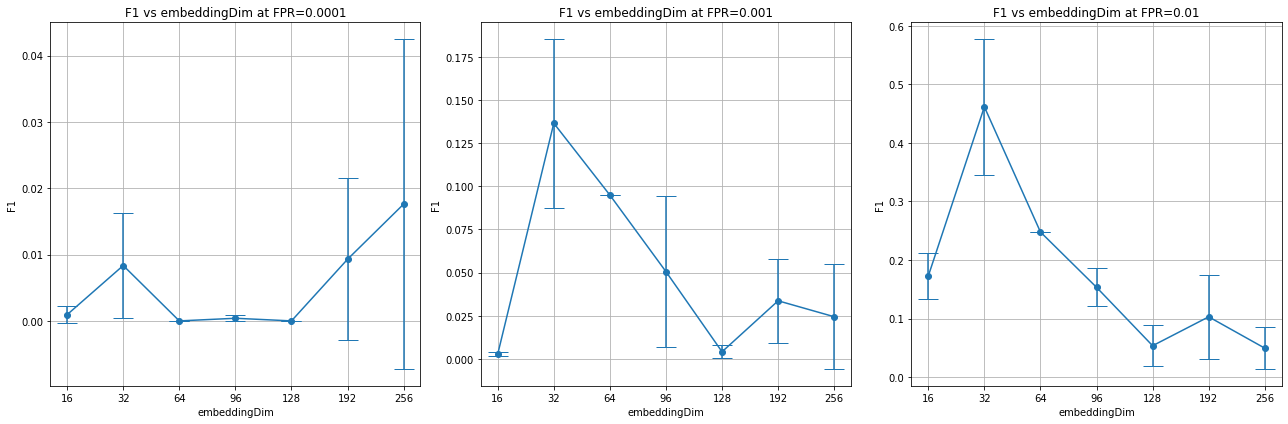

In [10]:
dfDict, timeDict = readCrossValidationFolder(inFolder, diffExtractor)
# make 6 plots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
# loop over axis
plotCrossValidationFieldvsKeys(dfDict, "f1", "embeddingDim", 0.0001, ax=ax[0])
plotCrossValidationFieldvsKeys(dfDict, "f1", "embeddingDim", 0.001, ax=ax[1])
plotCrossValidationFieldvsKeys(dfDict, "f1", "embeddingDim", 0.01, ax=ax[2])
plt.tight_layout()
plt.savefig(os.path.join(PLOT_OUT_FOLDER, "Transformer_F1_vs_EmbeddingDim.png"))

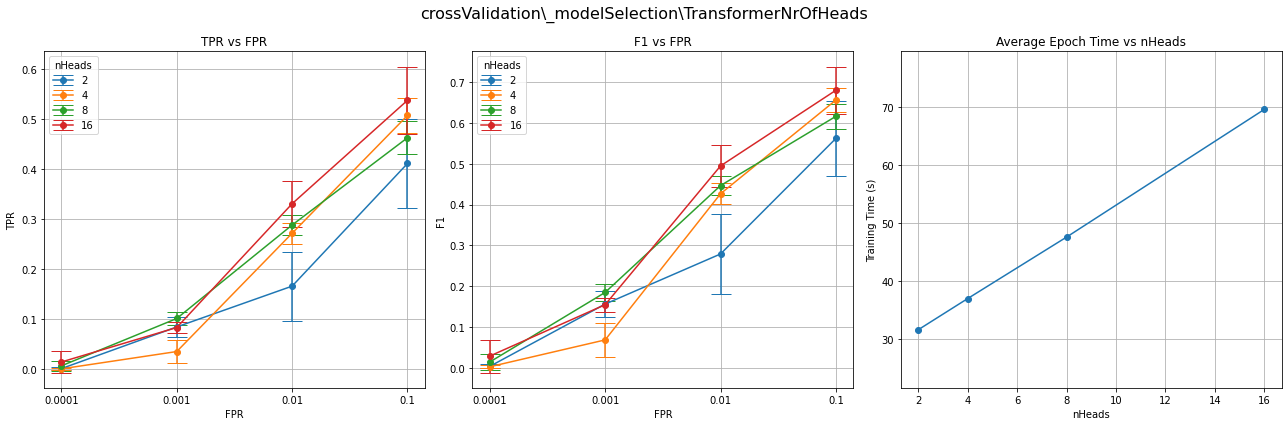

In [11]:
name = "TransformerNrOfHeads"
inFolder = os.path.join(cvFolder, name)
savePath = os.path.join(PLOT_OUT_FOLDER, f"{name}.png")

field = "nHeads"
diffExtractor = lambda x: x.split(field)[1].split("_")[1]

plotCrossValidationFolder(inFolder, field, diffExtractor, savePath=savePath)

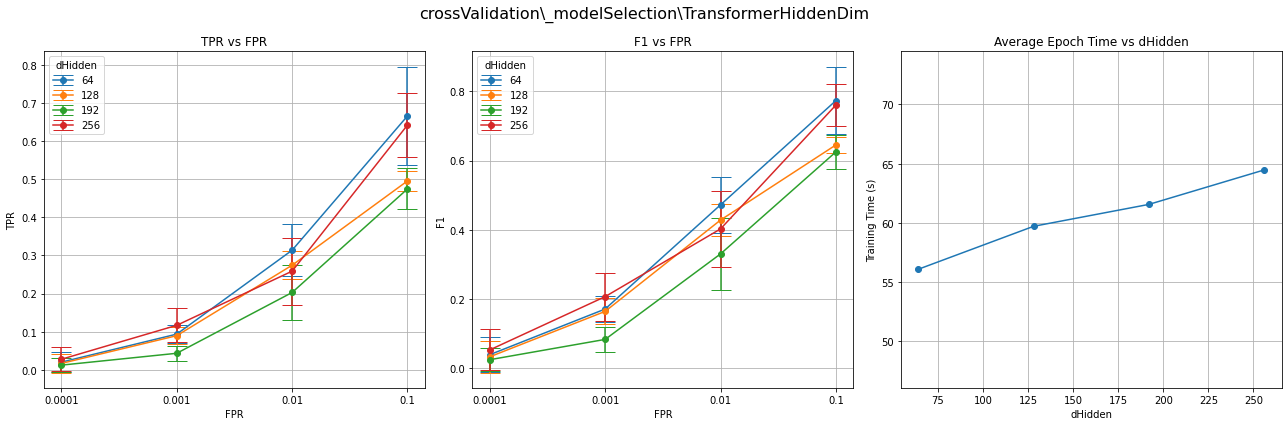

In [12]:
name = "TransformerHiddenDim"
inFolder = os.path.join(cvFolder, name)
savePath = os.path.join(PLOT_OUT_FOLDER, f"{name}.png")

field = "dHidden"
diffExtractor = lambda x: x.split(field)[1].split("_")[1]

plotCrossValidationFolder(inFolder, field, diffExtractor, savePath=savePath)

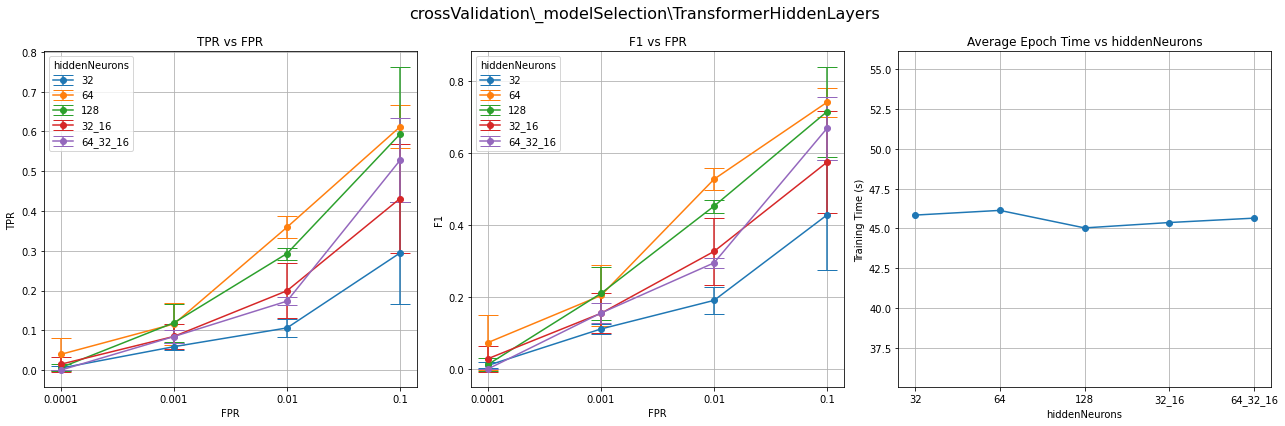

In [13]:
name = "TransformerHiddenLayers"
inFolder = os.path.join(cvFolder, name)
savePath = os.path.join(PLOT_OUT_FOLDER, f"{name}.png")

field = "hiddenNeurons"
diffExtractor = lambda x: x.split(field)[1].split("layerNorm")[0].strip("_")

plotCrossValidationFolder(inFolder, field, diffExtractor, savePath=savePath)

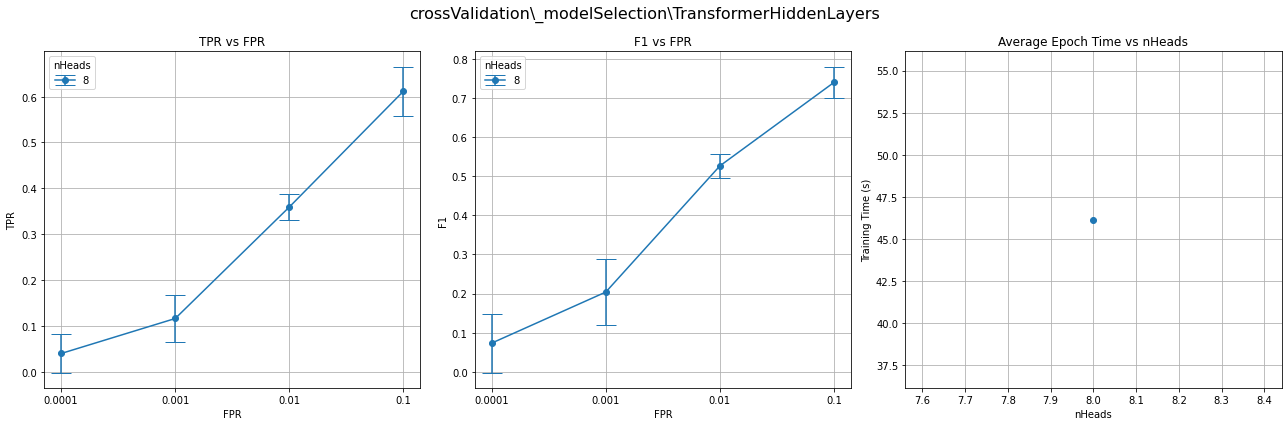

In [14]:
name = "TransformerHiddenLayers"
inFolder = os.path.join(cvFolder, name)
savePath = os.path.join(PLOT_OUT_FOLDER, f"{name}.png")

field = "nHeads"
diffExtractor = lambda x: x.split(field)[1].split("_")[1]

plotCrossValidationFolder(inFolder, field, diffExtractor, savePath=savePath)

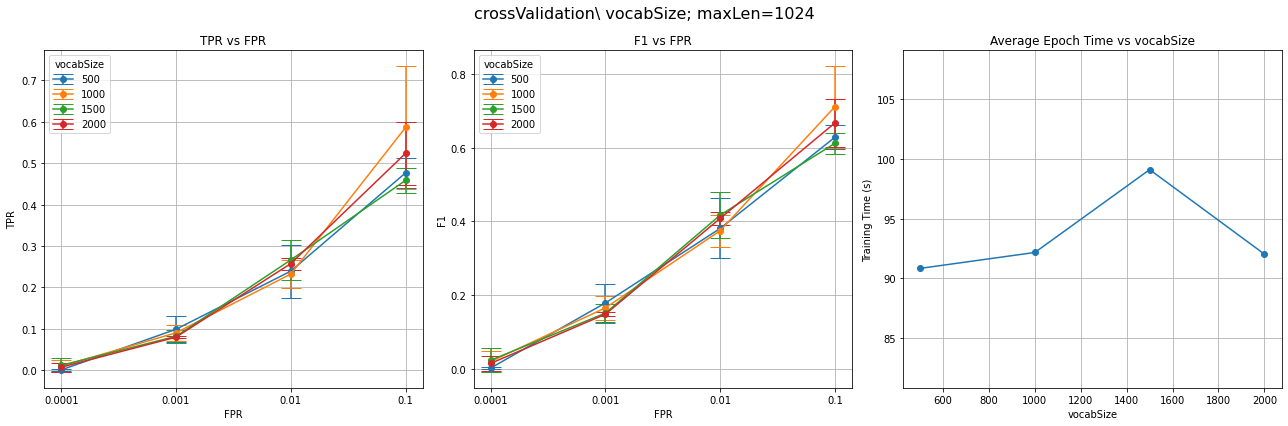

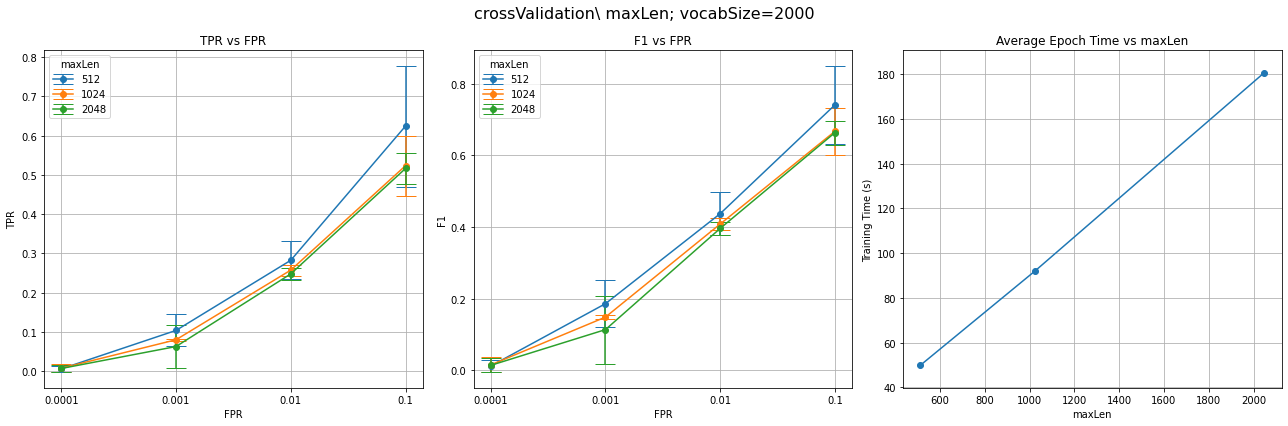

In [18]:
name = "Transformer_VocabSize_maxLen"
inFolder = os.path.join(cvFolder, name)
plotVocabSizeMaxLenTests(inFolder, PLOT_OUT_FOLDER)

### LSTM

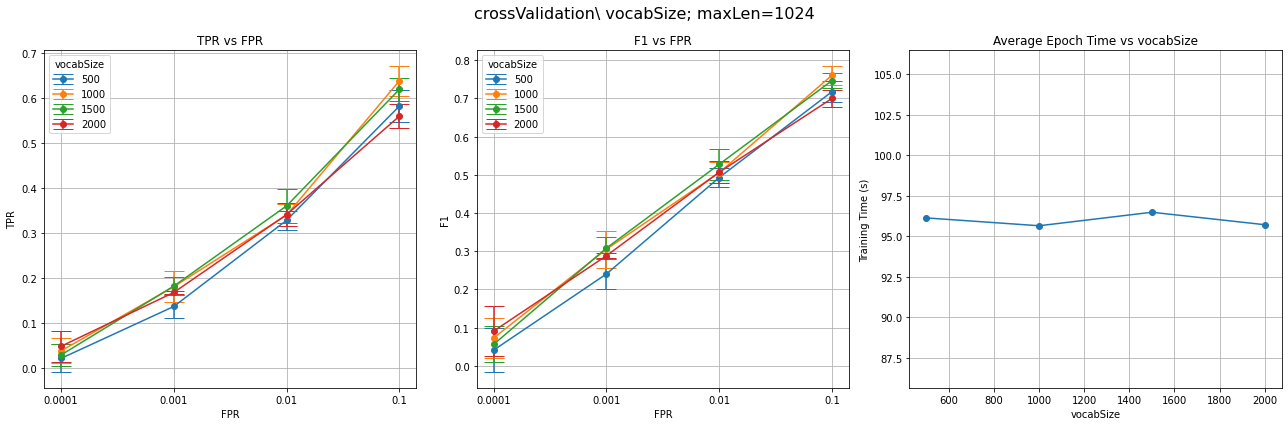

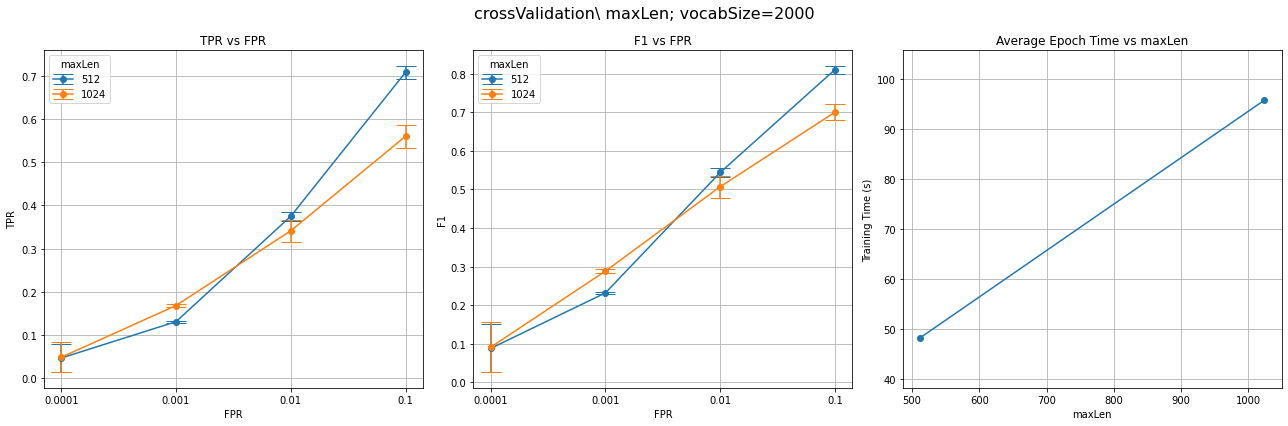

In [19]:
name = "LSTM_VocabSize_maxLen"
inFolder = os.path.join(cvFolder, name)
plotVocabSizeMaxLenTests(inFolder, PLOT_OUT_FOLDER)